In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates
from matplotlib.ticker import LinearLocator
from IPython.display import Image

%matplotlib inline

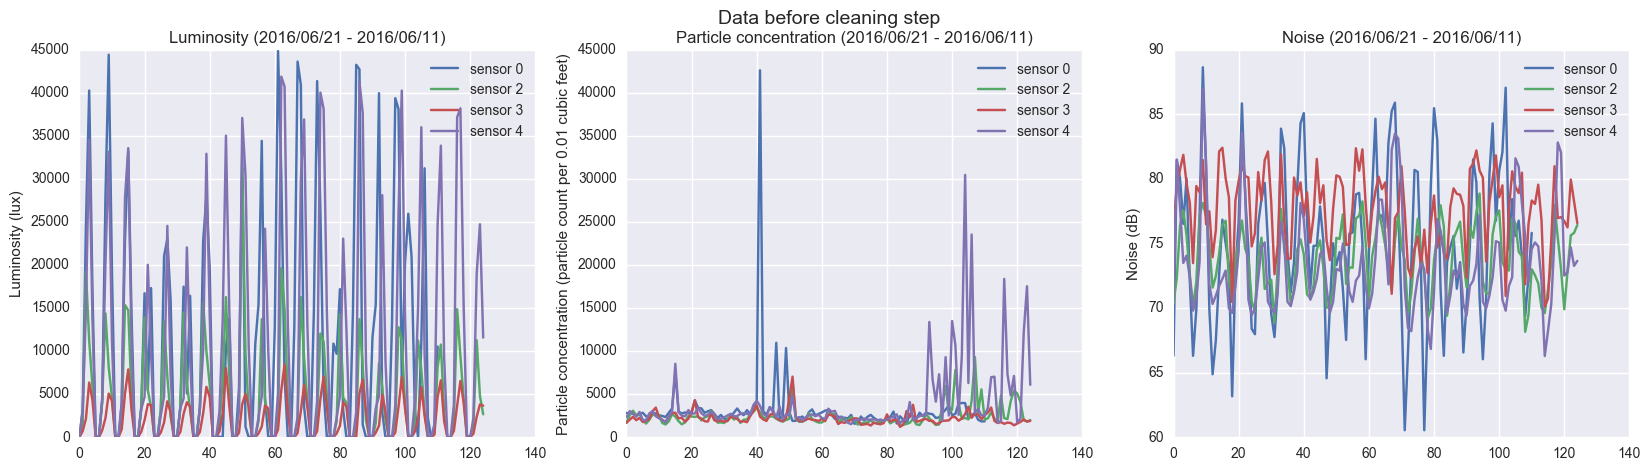

In [112]:
# Just to visualization, let's see data without cleaning for all 3 information: luminosity (lux), 
# particle concentration (particle count per 0.01 cubic feet) and noise level (dB)
fig = plt.figure(figsize = (20,5))
plt.suptitle('Data before cleaning step', fontsize = 14)
plt.subplot(1,3,1)

ax = fig.add_subplot(131)
plt.plot(s_0['lux'], label = "sensor 0")
plt.plot(s_2['lux'], label = "sensor 2")
plt.plot(s_3['lux'], label = "sensor 3")
plt.plot(s_4['lux'], label = "sensor 4")

plt.legend()
plt.ylabel('Luminosity (lux)')
plt.title('Luminosity (2016/06/21 - 2016/06/11)')

ax = fig.add_subplot(132)
plt.plot(s_0['con'], label = "sensor 0")
plt.plot(s_2['con'], label = "sensor 2")
plt.plot(s_3['con'], label = "sensor 3")
plt.plot(s_4['con'], label = "sensor 4")

plt.legend()
plt.ylabel('Particle concentration (particle count per 0.01 cubic feet)')
plt.title('Particle concentration (2016/06/21 - 2016/06/11)')

ax = fig.add_subplot(133)
plt.plot(s_0['spl'], label = "sensor 0")
plt.plot(s_2['spl'], label = "sensor 2")
plt.plot(s_3['spl'], label = "sensor 3")
plt.plot(s_4['spl'], label = "sensor 4")

plt.legend()
plt.ylabel('Noise (dB)')
plt.title('Noise (2016/06/21 - 2016/06/11)')

In [348]:
import shapely
# combine lat and lon to one column
loc['lonlat']=zip(loc.Longitude, loc.Latitude)
# Create Point Geometry for based on lonlat column
loc['geometry']=loc[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
loc.head()

,Latitude,Longitude,lonlat,geometry
Sensor_0,40.676847,-74.004704,"(-74.0047044, 40.6768465)",POINT (-74.00470439999999 40.6768465)
Sensor_2,40.677967,-74.019850,"(-74.0198497, 40.677967)",POINT (-74.01984969999999 40.677967)
Sensor_3,40.676847,-74.004704,"(-74.0047044, 40.6768465)",POINT (-74.00470439999999 40.6768465)
Sensor_4,40.679204,-74.014363,"(-74.0143632, 40.6792043)",POINT (-74.01436320000001 40.6792043)


### Downloading data and separating by sensor #

In [4]:
data = pd.read_csv('LuxDustNoise_summarized_4hour_0719.csv')

In [7]:
data.head(10)

,dt,sensor,lux,con,spl
0,2016-06-21 00:00:00,sensor_0,0.000,2834.03125,66.308479
1,2016-06-21 00:00:00,sensor_2,0.000,1691.99625,70.375943
2,2016-06-21 00:00:00,sensor_3,0.000,1686.44125,76.235738
3,2016-06-21 00:00:00,sensor_4,0.000,2324.65875,70.652334
4,2016-06-21 04:00:00,sensor_0,3213.500,2748.28875,81.467436
5,2016-06-21 04:00:00,sensor_2,1703.000,2550.94500,72.334450
6,2016-06-21 04:00:00,sensor_3,712.500,2041.33000,79.445869
7,2016-06-21 04:00:00,sensor_4,3057.750,3041.73875,81.499422
8,2016-06-21 08:00:00,sensor_0,24532.625,2720.35125,80.020600
9,2016-06-21 08:00:00,sensor_2,19257.500,3088.82750,76.372047


In [118]:
# Separating data by sensor
s_0 = data[data['sensor'] == 'sensor_0']
s_2 = data[data['sensor'] == 'sensor_2']
s_3 = data[data['sensor'] == 'sensor_3']
s_4 = data[data['sensor'] == 'sensor_4']

In [104]:
print (s_0.shape, s_2.shape, s_3.shape, s_4.shape)

((111, 5), (125, 5), (125, 5), (125, 5))


In [130]:
pd.Timestamp(s_0['dt'][0])

Timestamp('2016-06-21 00:00:00')

In [174]:
s_0.head(10)

,dt,sensor,lux,con,spl
0,2016-06-21 00:00:00,sensor_0,0.000,2834.03125,66.308479
1,2016-06-21 04:00:00,sensor_0,3213.500,2748.28875,81.467436
2,2016-06-21 08:00:00,sensor_0,24532.625,2720.35125,80.020600
3,2016-06-21 12:00:00,sensor_0,40268.250,2443.72875,76.525876
4,2016-06-21 16:00:00,sensor_0,17189.750,2717.49625,80.020600
5,2016-06-21 20:00:00,sensor_0,157.750,2839.57500,72.061800
6,2016-06-22 00:00:00,sensor_0,0.000,2451.52875,66.308479
7,2016-06-22 04:00:00,sensor_0,4075.875,2161.75000,69.917600
8,2016-06-22 08:00:00,sensor_0,27930.750,2714.79750,77.076297
9,2016-06-22 12:00:00,sensor_0,44426.625,2786.37125,88.647875


In [119]:
# reseting index to iterate while cleaning data
s_0 = s_0.reset_index(drop=True)
s_2 = s_2.reset_index(drop=True)
s_3 = s_3.reset_index(drop=True)
s_4 = s_4.reset_index(drop=True)

### Cleaning and plotting data

To clean data, we will eliminate everything that is 3 x standard deviation higher than the mean (for both sides)

In [137]:
# Transforming column 'dt' in a proper timestamp
for k in [s_0, s_2, s_3, s_4]:
    for i in range(0, len(k)):
        k['dt'][i] = pd.Timestamp(k['dt'][i])

/Users/adrianoyoshino/anaconda/envs/snakes/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


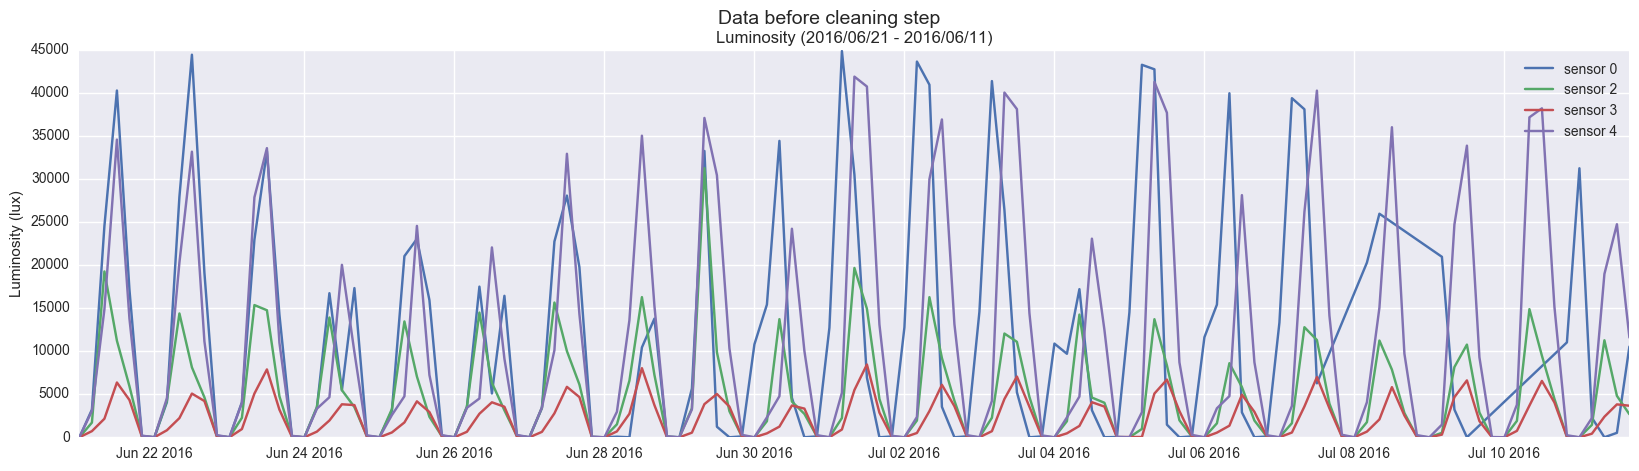

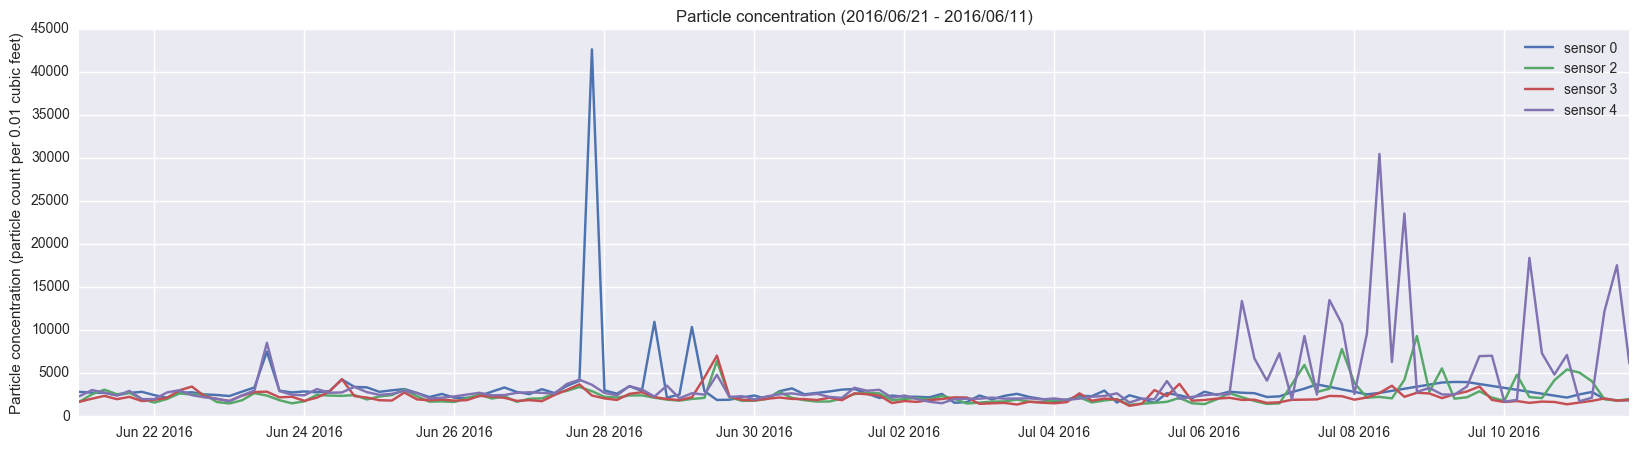

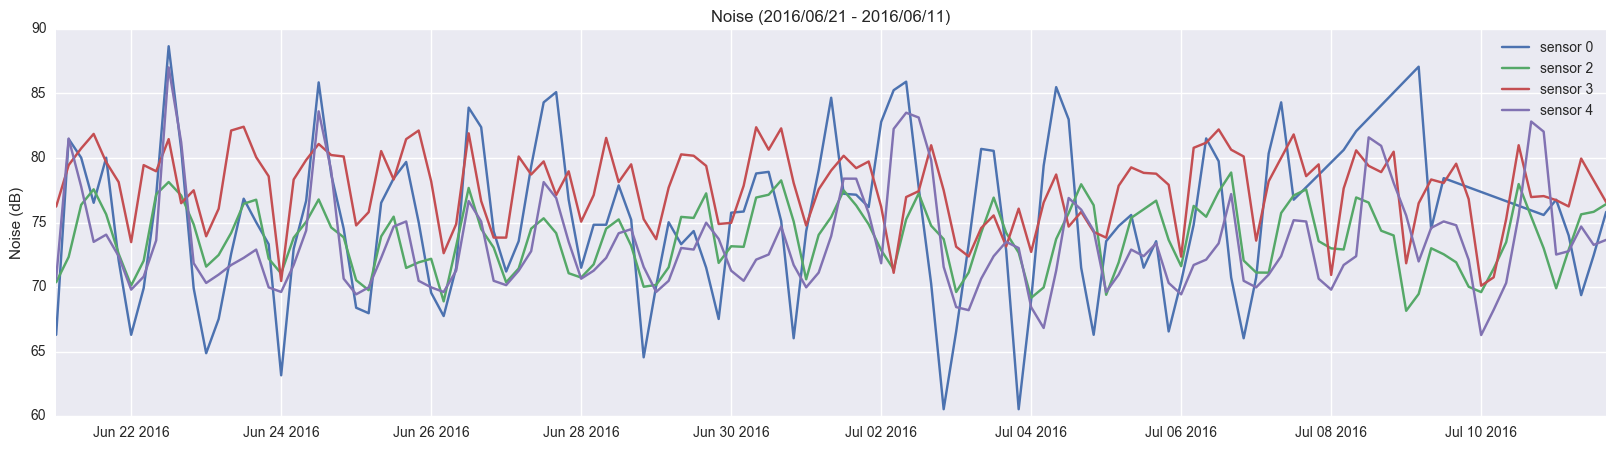

In [141]:
# Just to visualization, let's see data without cleaning for all 3 information: luminosity (lux), 
# particle concentration (particle count per 0.01 cubic feet) and noise level (dB)
fig = plt.figure(figsize = (20,5))

plt.plot(s_0['dt'], s_0['lux'], label = "sensor 0")
plt.plot(s_2['dt'], s_2['lux'], label = "sensor 2")
plt.plot(s_3['dt'], s_3['lux'], label = "sensor 3")
plt.plot(s_4['dt'], s_4['lux'], label = "sensor 4")

plt.legend()
plt.ylabel('Luminosity (lux)')
plt.title('Luminosity (2016/06/21 - 2016/07/11)')

fig = plt.figure(figsize = (20,5))
plt.plot(s_0['dt'], s_0['con'], label = "sensor 0")
plt.plot(s_2['dt'], s_2['con'], label = "sensor 2")
plt.plot(s_3['dt'], s_3['con'], label = "sensor 3")
plt.plot(s_4['dt'], s_4['con'], label = "sensor 4")

plt.legend()
plt.ylabel('Particle concentration (particle count per 0.01 cubic feet)')
plt.title('Particle concentration (2016/06/21 - 2016/07/11)')

fig = plt.figure(figsize = (20,5))
plt.plot(s_0['dt'], s_0['spl'], label = "sensor 0")
plt.plot(s_2['dt'], s_2['spl'], label = "sensor 2")
plt.plot(s_3['dt'], s_3['spl'], label = "sensor 3")
plt.plot(s_4['dt'], s_4['spl'], label = "sensor 4")

plt.legend()
plt.ylabel('Noise (dB)')
plt.title('Noise (2016/06/21 - 2016/07/11)')

<center>** Figure 1: Plot of Luminosity, Particle concentration and Noise data  **</center>

In [142]:
# Cleaning outliers (points that is higher or lower than 3*std from the average)
for k in [s_0, s_2, s_3, s_4]:
    for i in k.columns[2:]:
        for j in range(0, len(k)):
            avg = k[i].mean()
            std = k[i].std()
            if k[i][j] >= avg + 3 * std or k[i][j] <= avg - 3 * std:
                k[i][j] = avg

/Users/adrianoyoshino/anaconda/envs/snakes/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Plot after outliers cleaning

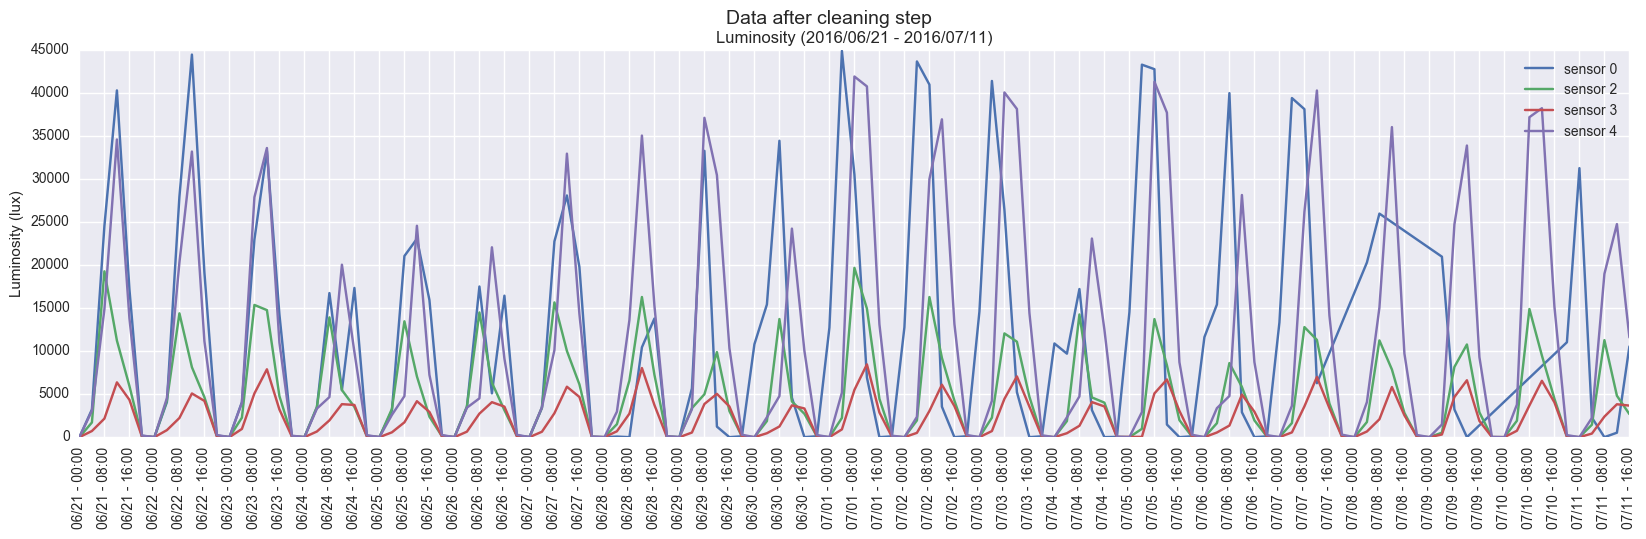

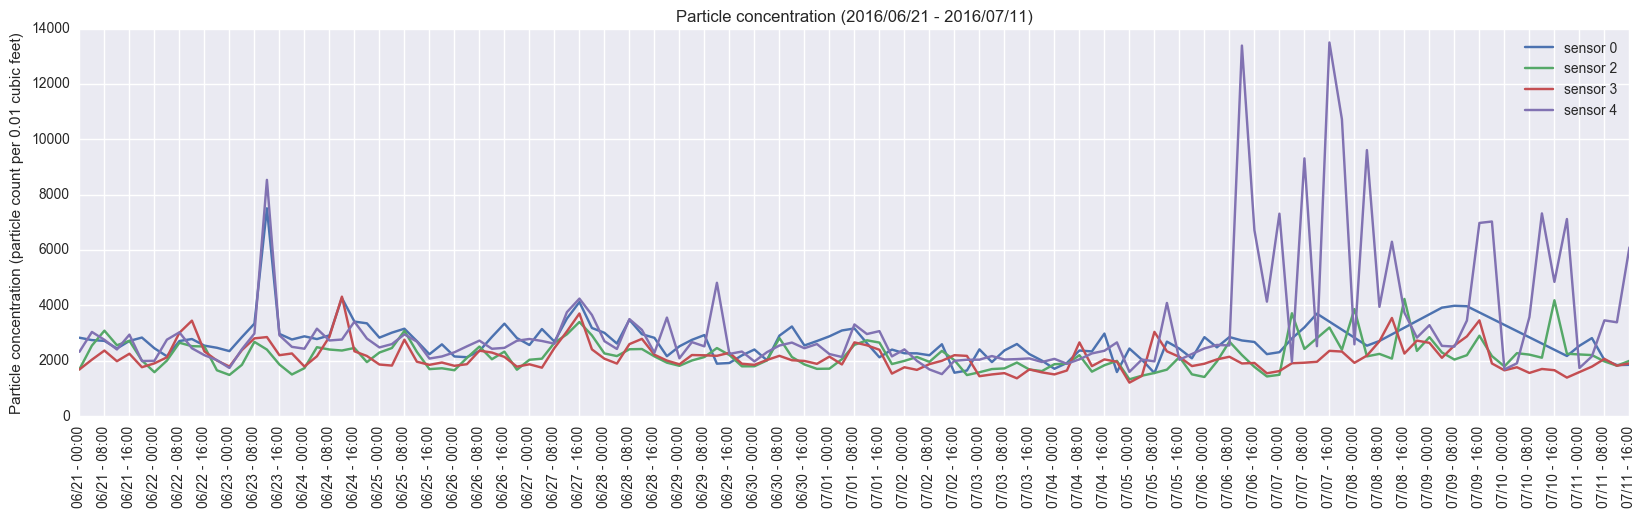

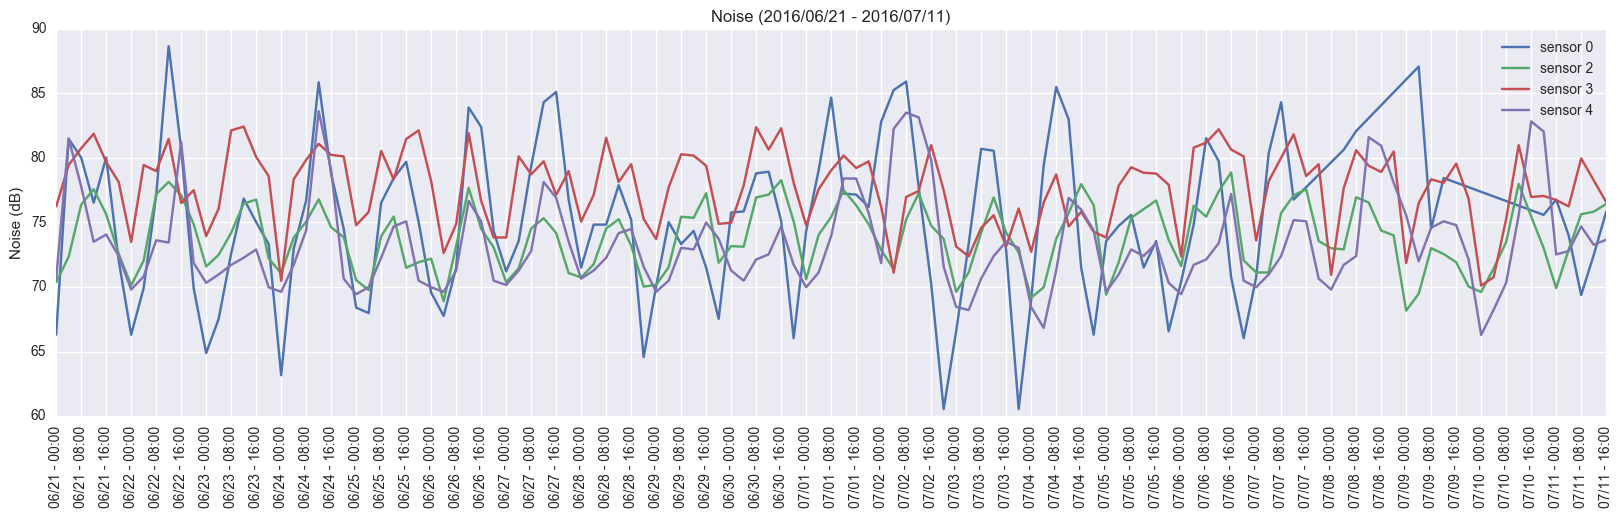

In [276]:
# Plot after outliers cleaning
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,1,1)  

plt.plot(s_0['dt'], s_0['lux'], label = "sensor 0")
plt.plot(s_2['dt'], s_2['lux'], label = "sensor 2")
plt.plot(s_3['dt'], s_3['lux'], label = "sensor 3")
plt.plot(s_4['dt'], s_4['lux'], label = "sensor 4")

plt.legend()
plt.ylabel('Luminosity (lux)')
plt.title('Luminosity (2016/06/21 - 2016/07/11)')
plt.xticks(rotation = 90)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=8)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d - %H:%M'))

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,1,1) 
plt.plot(s_0['dt'], s_0['con'], label = "sensor 0")
plt.plot(s_2['dt'], s_2['con'], label = "sensor 2")
plt.plot(s_3['dt'], s_3['con'], label = "sensor 3")
plt.plot(s_4['dt'], s_4['con'], label = "sensor 4")

plt.legend()
plt.ylabel('Particle concentration (particle count per 0.01 cubic feet)')
plt.title('Particle concentration (2016/06/21 - 2016/07/11)')
plt.xticks(rotation = 90)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=8)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d - %H:%M'))

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,1,1) 
plt.plot(s_0['dt'], s_0['spl'], label = "sensor 0")
plt.plot(s_2['dt'], s_2['spl'], label = "sensor 2")
plt.plot(s_3['dt'], s_3['spl'], label = "sensor 3")
plt.plot(s_4['dt'], s_4['spl'], label = "sensor 4")

plt.legend()
plt.ylabel('Noise (dB)')
plt.title('Noise (2016/06/21 - 2016/07/11)')
plt.xticks(rotation = 90)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=8)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d - %H:%M'))

<center>** Figure 2: Plot of Luminosity, Particle concentration and Noise data after cleaning Outliers  **</center>

### Time Series patterns

We can notice by looking at the plot that there is a daily pattern where the lowest values happen on 00:00 and 04:00, and peak values happen from 08:00 to 16:00. It happens to all three data, and obviously because at night there is no luminosity, less noise and less activities that produce particles on air.

More specifficaly:
- Sensors 0 and 4 receive less direct light than sensors 2 and 3;
- Particle concentration in sensor 4 location rise signifficantly on 07/06 and kept high values since then;
- Sensors 2 and 3 produced smooth values to all measurements. It can be caused by the sensor being located in a covered and less exposed place.

To check if there is another time series patterns, we  can use fourier transform technique to automatically identify them. This technique measure the power of transform based on the period (in this case each 4 hours), showing the period that present higher likelihood on having patterns. By the plots, we can see that predominantly there is only daily basis.


/Users/adrianoyoshino/anaconda/envs/snakes/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars
/Users/adrianoyoshino/anaconda/envs/snakes/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/Users/adrianoyoshino/anaconda/envs/snakes/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in double_scalars


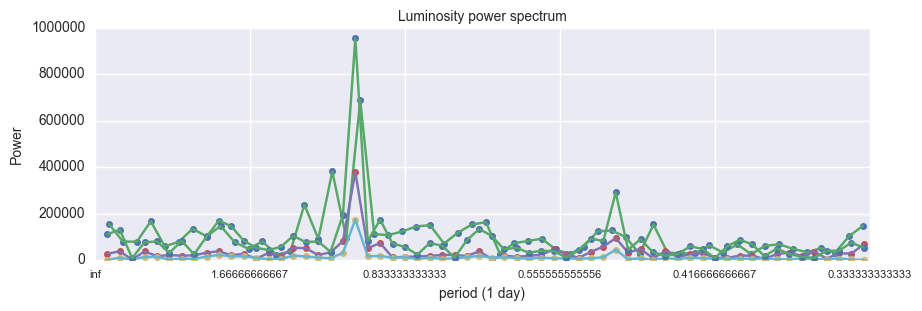

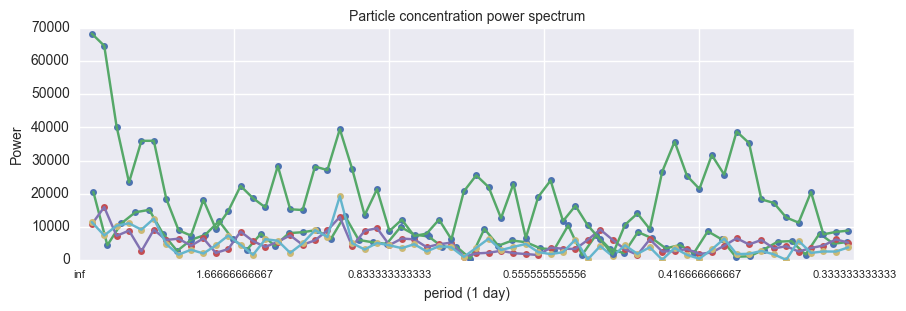

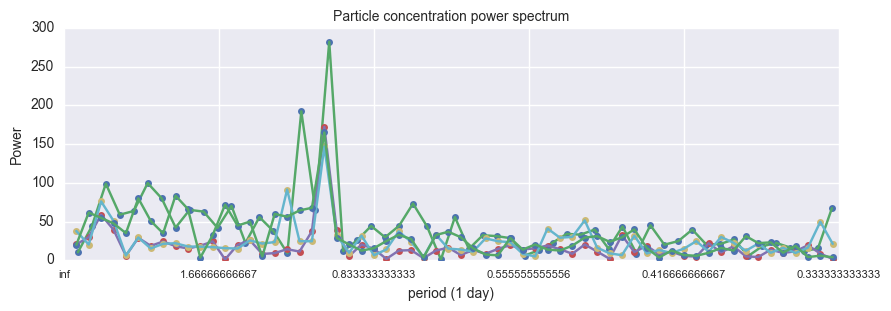

In [219]:
# Fourier transform for Luminosity
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
for k in [s_0, s_2, s_3, s_4]:
    N = len(k)
    f = np.abs(np.fft.rfft(k['lux']))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
ax.set_xticklabels([ "%s"%(1/6./f) for f in ax.get_xticks()], fontsize=8)
plt.xlabel("period (1 day)", fontsize=10)
plt.ylabel("Power", fontsize=10)
plt.title("Luminosity power spectrum", fontsize=10)

fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
for k in [s_0, s_2, s_3, s_4]:
    N = len(k)
    f = np.abs(np.fft.rfft(k['con']))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
ax.set_xticklabels([ "%s"%(1/6./f) for f in ax.get_xticks()], fontsize=8)
plt.xlabel("period (1 day)", fontsize=10)
plt.ylabel("Power", fontsize=10)
plt.title("Particle concentration power spectrum", fontsize=10)

fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(111)
for k in [s_0, s_2, s_3, s_4]:
    N = len(k)
    f = np.abs(np.fft.rfft(k['spl']))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
ax.set_xticklabels([ "%s"%(1/6./f) for f in ax.get_xticks()], fontsize=8)
plt.xlabel("period (1 day)", fontsize=10)
plt.ylabel("Power", fontsize=10)
plt.title("Particle concentration power spectrum", fontsize=10)

<center>** Figure 3: Fourier transform for all sensors and data **</center>

### Anomalous activities
After cleaning outliers, there are some possible anomalous activities that can be perceived on the plot:
- In luminosity data, sensor 0 show a anomalous pattern starting from 07/07. It happened because lack of data on 07/07, 07/08, 07/09 and 07/10; (figure 4)
- In Particle concentration data there is an anomalous behavior on sensor 4 from 07/06 to 07/11 (figure 5). The average value for sensor 4 is 3,277.66 particles per 0.01 cubic ft, and in this period the average is around 5,400, with peaks of 14,000;


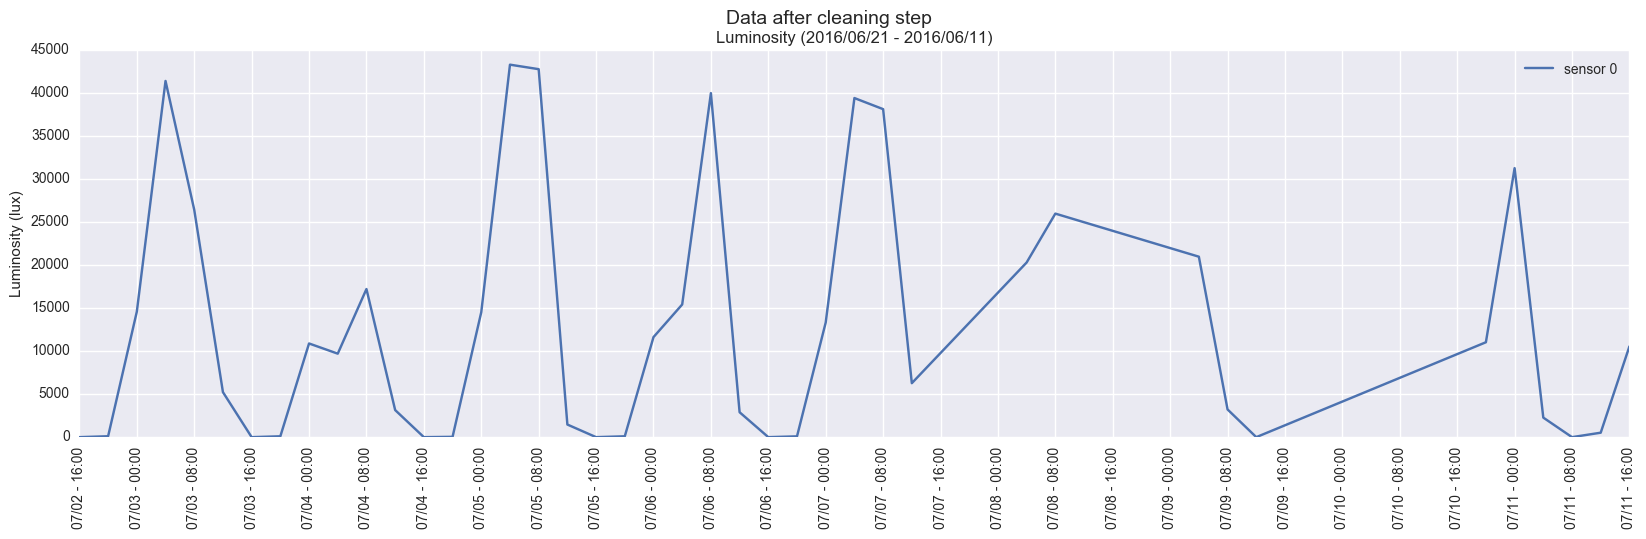

In [277]:

fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,1,1)  
plt.suptitle('Data after cleaning step', fontsize = 14)

plt.plot(s_0['dt'][70:], s_0['lux'][70:], label = "sensor 0")

plt.legend()
plt.ylabel('Luminosity (lux)')
plt.title('Luminosity (2016/06/21 - 2016/06/11)')
plt.xticks(rotation = 90)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=8)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d - %H:%M'))


<center>** Figure 4: Lack of data from 07/07 to 07/10 caused an anomalous shape on plot **</center>

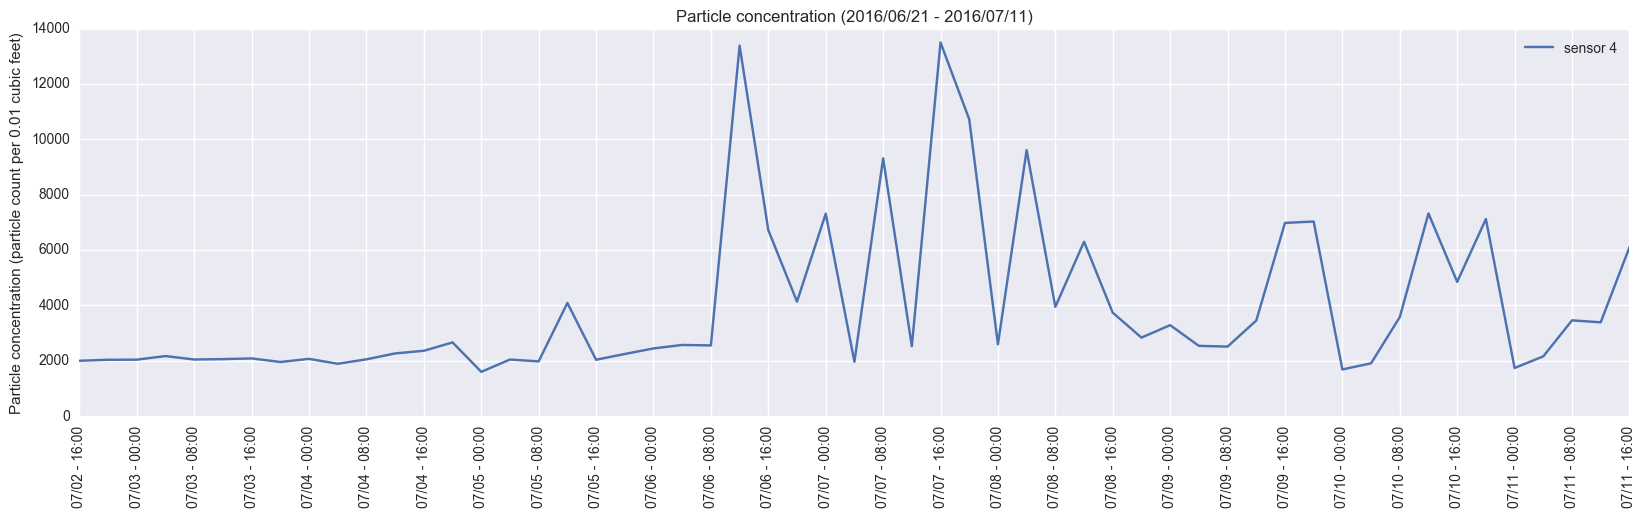

In [275]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(1,1,1)  

plt.plot(s_4['dt'][70:], s_4['con'][70:], label = "sensor 4")

plt.legend()
plt.ylabel('Particle concentration (particle count per 0.01 cubic feet)')
plt.title('Particle concentration (2016/06/21 - 2016/07/11)')
plt.xticks(rotation = 90)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=8)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d - %H:%M'))

<center>** Figure 5: Anomalous behavior found on particle concentration from 07/06 to 07/10 **</center>

### Air Quality weather and land use possible correlations

The sensors are located in:
- sensor_0 : RHI roof (at corner of Hicks and W 9th streets, elevation approx. 8m) - 767 Hicks St, Brooklyn, NY 11231
- sensor_3 : RHI entrance (on Hicks street at street level) - 767 Hicks St, Brooklyn, NY 11231
- sensor_2 : TechLab (at ground level) - 106 Ferris St
- sensor_4 : PioneerWorks roof (elevation approx. 15m) - 159 Pioneer St, Brooklyn, NY 11231

With the address it is possible to find the lat, lon and cross it with land use area on NYC PLUTO

In [329]:
import geopandas as gpd
path = '/Users/adrianoyoshino/amy324/NYU/2016 Fall Classes/Applied Data Science/Project/nyc_pluto_16v1'
bkPluto = gpd.read_file('bk_mappluto_16v2/BKMapPLUTO.shp')

In [478]:
bkPluto.head(3)

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry,longitude,latitude
0,0.0,None,BEACH RESERVATION,4,2241.0,2241.0,3.070360e+09,0,V0,0.0,...,None,11224,R3-1,None,None,None,28b,"POLYGON ((980812.9622000009 149656.1661999971,...",-77.519584,40.112385
1,0.0,None,BEACH 46 STREET,4,822.0,822.0,3.070370e+09,0,V0,0.0,...,None,11224,R3-1,None,None,None,28b,"POLYGON ((980811.0732000023 149338.8654000014,...",-77.519584,40.112385
2,0.0,None,JONES WALK,4,74250.0,74250.0,3.086960e+09,0,V1,0.0,...,None,11224,C7,None,None,None,28d,"POLYGON ((990137.3931999952 148647.5088, 99011...",-73.978866,40.574355


In [411]:
print "sensor_0 Land Use:", bkPluto[bkPluto['Address'].str.contains("767 HICKS")==True]['LandUse'].values[0]
print "sensor_2 Land Use:", bkPluto[bkPluto['Address'].str.contains("106 FERRIS")==True]['LandUse'].values[0]
print "sensor_3 Land Use:", bkPluto[bkPluto['Address'].str.contains("767 HICKS")==True]['LandUse'].values[0]
print "sensor_4 Land Use:", bkPluto[bkPluto['Address'].str.contains("157 PIONEER")==True]['LandUse'].values[0]

sensor_0 Land Use: 06
sensor_2 Land Use: 06
sensor_3 Land Use: 06
sensor_4 Land Use: 06


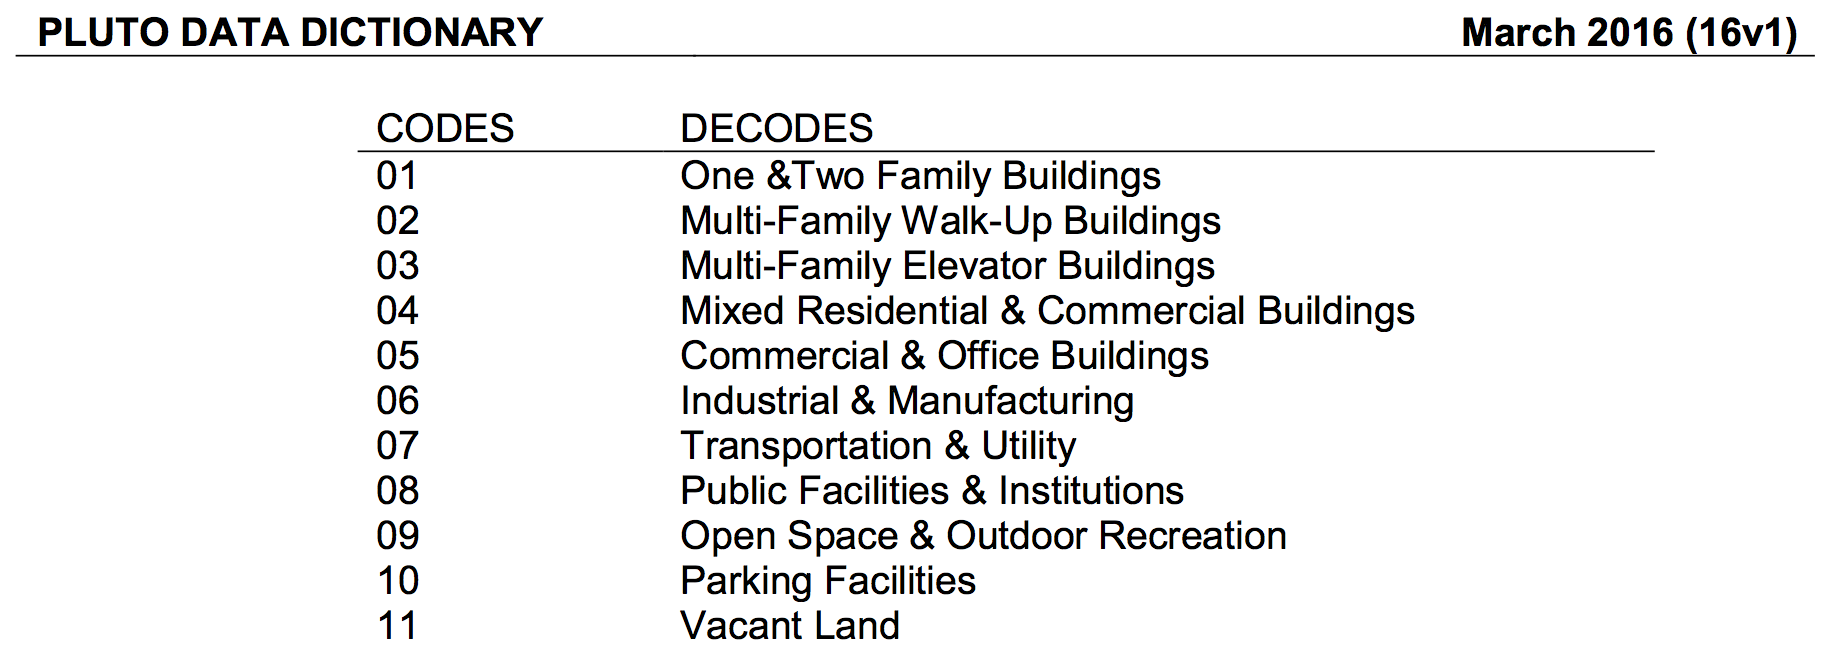

In [406]:
Image('PLUTOLandUse.png')

According to the PLUTO data dictionary, the land use of those places is Industrial & Manufacturing. As all sensors are located in the same land use type, it is not possible to see the difference between land uses.

In [414]:
# For temperature and humidity the closest point found is Manhattan Downtown on:
# https://www.wunderground.com/history/airport/KJRB/2016/6/28/DailyHistory.html
# We are going to use the average temperature, humidity and wind to this analysis

weather = pd.read_excel('weather_jun_jul_2016.xlsx')
weather = weather[[u'Date', u'Temp avg (F)', u'Humidity avg (%)', 
                   u'Wind avg (mph)', u'Precip']]
weather = weather.iloc[20:-4]  #using just the part from 06/21 to 07/11
weather = weather.reset_index(drop=True)
weather.head()

,Date,Temp avg (F),Humidity avg (%),Wind avg (mph),Precip
0,2016-06-21,80,48,6,0.0
1,2016-06-22,78,40,3,0.0
2,2016-06-23,74,60,3,0.0
3,2016-06-24,76,64,6,0.0
4,2016-06-25,74,64,7,0.0


In [471]:
# Extracting day to make mean
for k in [s_0, s_2, s_3, s_4]:
    a = []
    for i in k['dt']:
        a.append(i.to_datetime().day)
    k['day'] = a

# Days on weather dataset to merge purposes
a = []
for i in weather['Date']:
    a.append(i.to_datetime().day)
weather['day'] = a

In [438]:
days = s_0['day'].unique()

In [467]:
#create dataframe to store means of luminosity, particle concentration and noise levels per day
weatComp = pd.DataFrame(days)

In [468]:
a = ['s_0', 's_2', 's_3', 's_4']
j = 0
for k in [s_0, s_2, s_3, s_4]:
    lux = []
    part = []
    noise = []
    for i in days:
        lux.append(s_0[s_0['day'] == i].mean()[0])
        part.append(s_0[s_0['day'] == i].mean()[1])
        noise.append(s_0[s_0['day'] == i].mean()[2])
    weatComp[a[j] + ' lux'] = lux
    weatComp[a[j] + ' particle'] = part
    weatComp[a[j] + ' noise'] = noise
    j = j + 1

In [473]:
# Average of all sensor on each day
weatComp.head()

,0,s_0 lux,s_0 particle,s_0 noise,s_2 lux,s_2 particle,s_2 noise,s_3 lux,s_3 particle,s_3 noise,s_4 lux,s_4 particle,s_4 noise
0,21,14226.979167,2717.245208,76.067465,14226.979167,2717.245208,76.067465,14226.979167,2717.245208,76.067465,14226.979167,2717.245208,76.067465
1,22,15952.750000,2522.080208,75.427829,15952.750000,2522.080208,75.427829,15952.750000,2522.080208,75.427829,15952.750000,2522.080208,75.427829
2,23,12436.000000,3633.355417,71.699026,12436.000000,3633.355417,71.699026,12436.000000,3633.355417,71.699026,12436.000000,3633.355417,71.699026
3,24,7185.000000,3270.930417,75.322384,7185.000000,3270.930417,75.322384,7185.000000,3270.930417,75.322384,7185.000000,3270.930417,75.322384
4,25,10543.958333,2758.851875,74.339227,10543.958333,2758.851875,74.339227,10543.958333,2758.851875,74.339227,10543.958333,2758.851875,74.339227


In [477]:
# Merged dataset:  sensors <--> weather data
weatherMerged = weatComp.merge(weather, left_on = 0, right_on = 'day')
weatherMerged.head()

,0,s_0 lux,s_0 particle,s_0 noise,s_2 lux,s_2 particle,s_2 noise,s_3 lux,s_3 particle,s_3 noise,s_4 lux,s_4 particle,s_4 noise,Date,Temp avg (F),Humidity avg (%),Wind avg (mph),Precip,day
0,21,14226.979167,2717.245208,76.067465,14226.979167,2717.245208,76.067465,14226.979167,2717.245208,76.067465,14226.979167,2717.245208,76.067465,2016-06-21,80,48,6,0.0,21
1,22,15952.750000,2522.080208,75.427829,15952.750000,2522.080208,75.427829,15952.750000,2522.080208,75.427829,15952.750000,2522.080208,75.427829,2016-06-22,78,40,3,0.0,22
2,23,12436.000000,3633.355417,71.699026,12436.000000,3633.355417,71.699026,12436.000000,3633.355417,71.699026,12436.000000,3633.355417,71.699026,2016-06-23,74,60,3,0.0,23
3,24,7185.000000,3270.930417,75.322384,7185.000000,3270.930417,75.322384,7185.000000,3270.930417,75.322384,7185.000000,3270.930417,75.322384,2016-06-24,76,64,6,0.0,24
4,25,10543.958333,2758.851875,74.339227,10543.958333,2758.851875,74.339227,10543.958333,2758.851875,74.339227,10543.958333,2758.851875,74.339227,2016-06-25,74,64,7,0.0,25


### Plotting averages with weather information to see if there are correlations
The relation of luminosity, particle concentration and noise with temperature can be perceived on the plots below. There is a high correlation between temperature and luminosity, an inverse correlation between temperature and particle emission (when temperature is high, particle presence decrease in all sensors), and there is no conclusive signs of relation between temperature and noise levels)

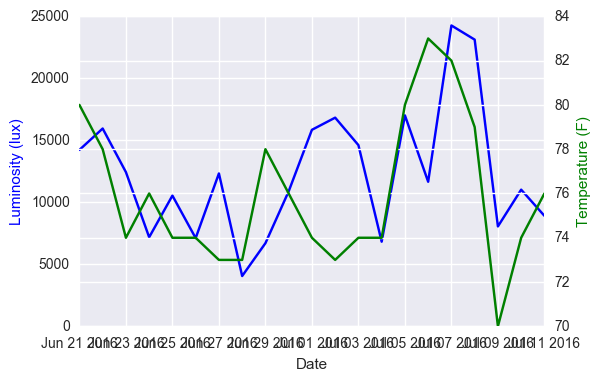

In [530]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(weatherMerged['Date'], weatherMerged['s_0 lux'], '-b')
ax2.plot(weatherMerged['Date'], weatherMerged['Temp avg (F)'], 'g')

ax1.set_xlabel('Date')
ax1.set_ylabel('Luminosity (lux)', color='b')
ax2.set_ylabel('Temperature (F)', color='g')


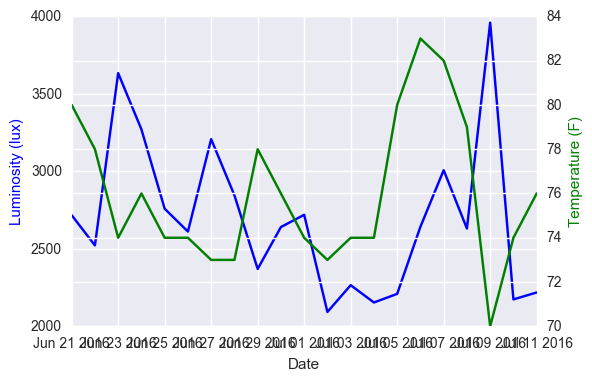

In [536]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(weatherMerged['Date'], weatherMerged['s_2 particle'], '-b')
ax2.plot(weatherMerged['Date'], weatherMerged['Temp avg (F)'], 'g')

ax1.set_xlabel('Date')
ax1.set_ylabel('Luminosity (lux)', color='b')
ax2.set_ylabel('Temperature (F)', color='g')


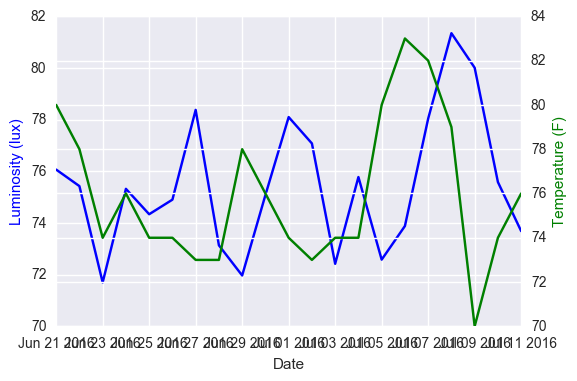

In [538]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(weatherMerged['Date'], weatherMerged['s_0 noise'], '-b')
ax2.plot(weatherMerged['Date'], weatherMerged['Temp avg (F)'], 'g')

ax1.set_xlabel('Date')
ax1.set_ylabel('Luminosity (lux)', color='b')
ax2.set_ylabel('Temperature (F)', color='g')
